# **XLM-ROBERTA-BASE PHASE 2**

This phase uses the `Sentiment-analysis-for-menttal-health.csv` dataset

**Source:** [sentiment-analysis-for-mental-health](https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health) 

---

## **Setup & Imports**

In [1]:
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers.trainer_utils import get_last_checkpoint
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils import resample
from torch.nn import CrossEntropyLoss
import torch
import torch.nn as nn
import torch.nn.functional as F
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from tqdm import tqdm
from typing import List
from collections import Counter
import langid
import pycountry
from wordcloud import WordCloud

---
## **Configurations**

In [22]:
DATA_PATH = "../../../data/nlp/Sentiment-analysis-for-mental-health.csv"
MODEL_NAME = "xlm-roberta-base"

MODEL_PATH_FINETUNE = "../../../models/nlp/xlm-roberta/phase-2/sentiment_finetune"
MODEL_PATH_MODEL = "../../../models/nlp/xlm-roberta/phase-2/sentiment_model"
MODEL_PATH_MODEL_1 = "../../../models/nlp/xlm-roberta/phase-1/sentiment_model"

---
## **Load Data**

In [8]:
# Load two datasets
dataset = load_dataset("csv", data_files=DATA_PATH)

# Define functions to rename datasets
def rename_data_columns(data: Dataset, column_names_to_change: List[str], new_column_names: List[str]) -> Dataset:
    if len(column_names_to_change) != len(new_column_names):
        raise ValueError("Both lists must have the same length.")
    
    dataset = data
    for old_name, new_name in zip(column_names_to_change, new_column_names):
        dataset = dataset.rename_column(old_name, new_name)

    print(dataset)
    
    return dataset

# Remove unwanted column
dataset = dataset.remove_columns(["Unnamed: 0"])

# Rename
print("\nDataset: tweet_emotions")

dataset = rename_data_columns(
    data=dataset,
    column_names_to_change=['status', 'statement'],
    new_column_names=['labels', 'text']
  )



Dataset: tweet_emotions
DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 53043
    })
})


---
## **Data Pre-Processing & Visualization**

### **1. Check Unique Labels**

labels
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


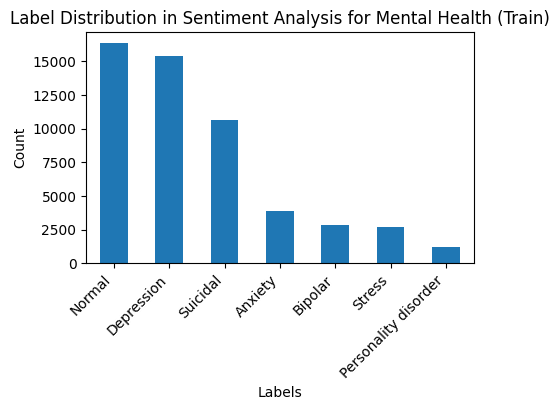

In [9]:
def label_visualization():
  # Convert data to pandas dataframe for visualization
  df = dataset["train"].to_pandas()

  # Count label frequencies
  label_df_counts = df["labels"].value_counts()
  print(label_df_counts)

  # Plot distribution for df_dataset_1
  plt.figure(figsize=(5, 3))
  label_df_counts.plot(kind="bar")
  plt.xticks(rotation=45, ha="right")
  plt.title("Label Distribution in Sentiment Analysis for Mental Health (Train)")
  plt.xlabel("Labels")
  plt.ylabel("Count")
  plt.show()

label_visualization()

### **2. Remove Special Characters**

In [10]:
def clean_text(example):
    text = example.get("text", "")

    if text is None or not isinstance(text, str) or text.strip() == "":
        return {"text": ""}   # keep it empty; will be dropped later

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove newlines and other non-word characters except spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return {"text": text}

dataset = dataset.map(clean_text)

dataset["train"].to_pandas().head()

Map:   0%|          | 0/53043 [00:00<?, ? examples/s]

,text,labels
0,oh my gosh,Anxiety
1,trouble sleeping confused mind restless heart ...,Anxiety
2,all wrong back off dear forward doubt stay in ...,Anxiety
3,ive shifted my focus to something else but im ...,Anxiety
4,im restless and restless its been a month now ...,Anxiety


### **3. Check For Rows That Has Null or Blank Values**

In [11]:
def check_for_null_blank(dataset, dataset_name="Dataset"):
    import pandas as pd

    # If it's a DatasetDict, loop over splits
    if hasattr(dataset, "keys"):  # DatasetDict
        for split in dataset.keys():
            print(f"Checking split: {split} in {dataset_name}\n")
            df = dataset[split].to_pandas()
            
            # Nulls
            print("Nulls in each column:")
            print(df[["text", "labels"]].isnull().sum())
            print("\n")
            
            # Rows with nulls
            print("Rows where text or labels are null/blank:")
            print(df[df["text"].isnull() | df["labels"].isnull()])
            print("\n")
            
            # Blank strings
            print("Check for blank and empty string values:")
            print("Blank texts:", (df["text"].str.strip() == "").sum())
            print("Blank labels:", (df["labels"].astype(str).str.strip() == "").sum())
            print("\n")
    else:  # Single Dataset
        df = dataset.to_pandas()
        print(f"Checking {dataset_name}\n")
        print("Nulls in each column:")
        print(df[["text", "labels"]].isnull().sum())
        print("\n")
        print("Rows where text or labels are null/blank:")
        print(df[df["text"].isnull() | df["labels"].isnull()])
        print("\n")
        print("Check for blank and empty string values:")
        print("Blank texts:", (df["text"].str.strip() == "").sum())
        print("Blank labels:", (df["labels"].astype(str).str.strip() == "").sum())
        print("\n")

check_for_null_blank(dataset=dataset, dataset_name="tweet-emotions")

Checking split: train in tweet-emotions

Nulls in each column:
text      0
labels    0
dtype: int64


Rows where text or labels are null/blank:
Empty DataFrame
Columns: [text, labels]
Index: []


Check for blank and empty string values:
Blank texts: 369
Blank labels: 0




### **4. Drop Rows That Has Null/Blank/Empty String Values**

In [12]:
# Drop rows where statement or status is null
def drop_nulls_from_dataset(dataset, columns=["text", "labels"]):
    """
    Drops null and blank values from a Dataset or DatasetDict.
    Works for both cases.
    """
    if isinstance(dataset, DatasetDict):  # Case 1: DatasetDict with train/test
        cleaned_splits = {}
        for split_name, ds_split in dataset.items():
            df = ds_split.to_pandas()
            df = df.dropna(subset=columns)
            if "text" in columns:
                df = df[df["text"].str.strip() != ""]
            cleaned_splits[split_name] = Dataset.from_pandas(df)
            print(f"✅ Cleaned {split_name}: {len(ds_split)} → {len(df)} rows")
        return DatasetDict(cleaned_splits)

    elif isinstance(dataset, Dataset):  # Case 2: Single Dataset
        df = dataset.to_pandas()
        df = df.dropna(subset=columns)
        if "text" in columns:
            df = df[df["text"].str.strip() != ""]
        cleaned_dataset = Dataset.from_pandas(df)
        print(f"✅ Cleaned dataset: {len(dataset)} → {len(df)} rows")
        return cleaned_dataset

    else:
        raise TypeError("Expected Dataset or DatasetDict")

dataset = drop_nulls_from_dataset(dataset=dataset)

# Check counts again
check_for_null_blank(dataset);

✅ Cleaned train: 53043 → 52674 rows
Checking split: train in Dataset

Nulls in each column:
text      0
labels    0
dtype: int64


Rows where text or labels are null/blank:
Empty DataFrame
Columns: [text, labels, __index_level_0__]
Index: []


Check for blank and empty string values:
Blank texts: 0
Blank labels: 0




### **5. Feature Engineering**

Filter:   0%|          | 0/49897 [00:00<?, ? examples/s]


Final dataset size: 1
DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 48820
    })
})
labels
Normal        16339
Depression    15404
Suicidal      10649
Anxiety        3841
Stress         2587
Name: count, dtype: int64


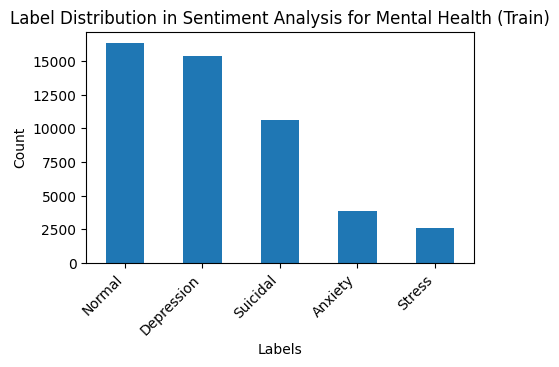

In [14]:
# Remove unwanted column/feature
# Based on the graphs above i don't want "Bipolar", "Personality Disorder"
unwanted_labels_1 = ["Bipolar", "Personality disorder"]
dataset["train"] = dataset["train"].filter(
    lambda example: example["labels"] not in unwanted_labels_1
)

print("\nFinal dataset size:", len(dataset))
print(dataset)

label_visualization()

### **6. Detect Languages Inside The Dataset**

In [15]:
df_detect_lang = dataset['train'].to_pandas()

# Add language detection column
df_detect_lang['lang'] = df_detect_lang['text'].apply(lambda text: langid.classify(str(text))[0])

# If you want counts of languages
lang_counts = Counter(df_detect_lang['lang'])
print(lang_counts)

Counter({'en': 47108, 'es': 173, 'fr': 172, 'de': 147, 'it': 145, 'id': 137, 'nl': 84, 'da': 63, 'sw': 54, 'pt': 52, 'cy': 49, 'sv': 48, 'mt': 46, 'tl': 46, 'pl': 45, 'et': 38, 'no': 36, 'ms': 33, 'fi': 31, 'sl': 29, 'hr': 26, 'af': 20, 'ca': 17, 'br': 17, 'hu': 17, 'mg': 16, 'eu': 16, 'lt': 15, 'ro': 14, 'rw': 11, 'jv': 10, 'eo': 9, 'az': 8, 'xh': 8, 'sq': 8, 'nn': 6, 'cs': 6, 'la': 6, 'lv': 5, 'oc': 5, 'ga': 4, 'gl': 4, 'se': 4, 'zu': 4, 'wa': 4, 'ht': 4, 'tr': 4, 'qu': 3, 'sk': 3, 'an': 3, 'bs': 2, 'fo': 2, 'zh': 1, 'lb': 1, 'ku': 1})


In [16]:
# map code -> full language name
def code_to_name(code):
    try:
        return pycountry.languages.get(alpha_2=code).name
    except:
        return "Unknown"

df_langs = pd.DataFrame([
    {"Code": code, "Language": code_to_name(code), "Count": count}
    for code, count in lang_counts.items()
])

# Sort by frequency
df_langs = df_langs.sort_values(by="Count", ascending=False).reset_index(drop=True)

# Optional: check Tagalog rows
print(df_detect_lang[df_detect_lang['lang'] == 'tl'].sample(10)['text'])

print(df_langs)

3708     trading k iahellos royalehighdiamonds rhdiamon...
4464                                         yoyo bakayaro
5083                               jidi read hyunas bot xd
1167                           always success salshaabilaa
3895                                 ambot sa imu jungkook
949                       paras ng ulqm sinigang gang gang
42709    glavas lol u read my bio but spelt my name wro...
3065     yes or no na nga lang hindi pa magawang saguta...
5168                          lutang takon aga paaa huehue
6337     ueuweuwu ang labo na talaga ng mata q nasa ple...
Name: text, dtype: object
   Code                 Language  Count
0    en                  English  47108
1    es                  Spanish    173
2    fr                   French    172
3    de                   German    147
4    it                  Italian    145
5    id               Indonesian    137
6    nl                    Dutch     84
7    da                   Danish     63
8    sw  Swahili (macrol

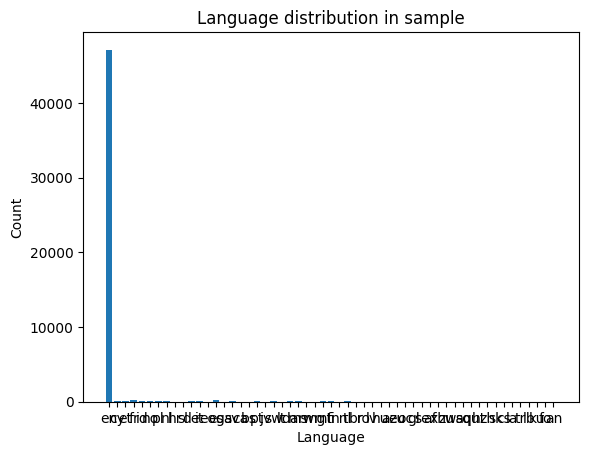

In [17]:
# language distribution
plt.bar(lang_counts.keys(), lang_counts.values())
plt.title("Language distribution in sample")
plt.xlabel("Language")
plt.ylabel("Count")
plt.show()

### **7. Create Word Cloud**

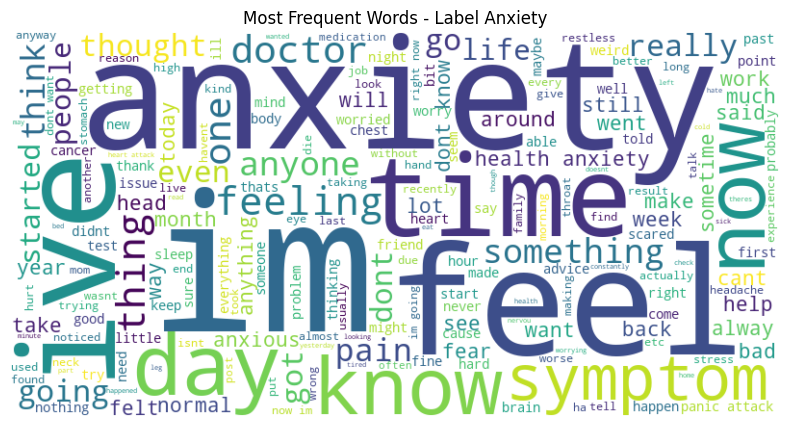

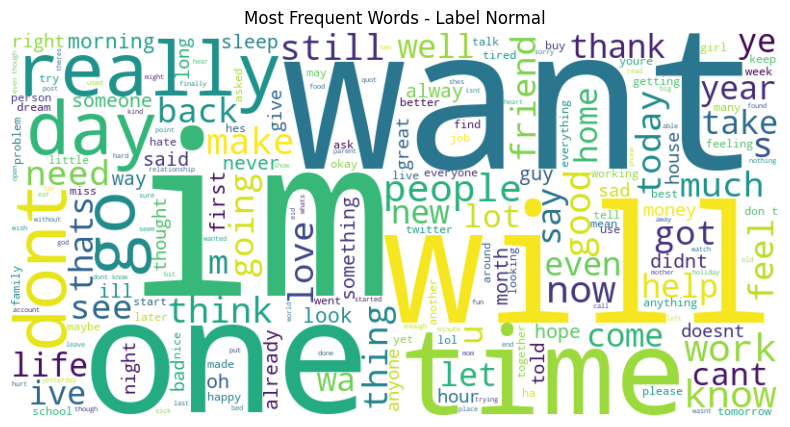

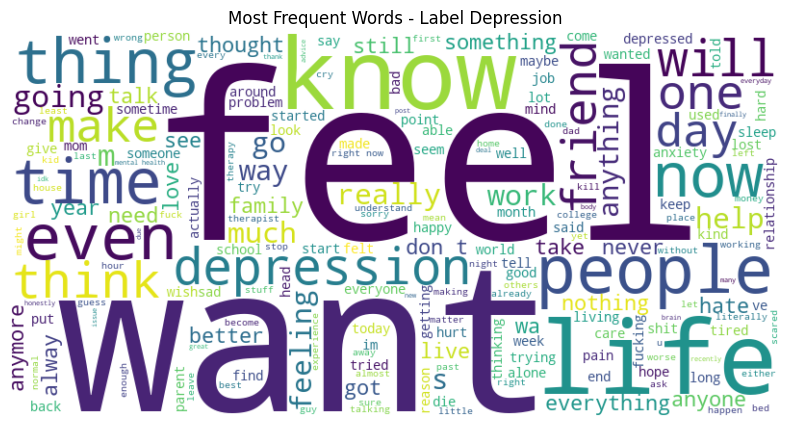

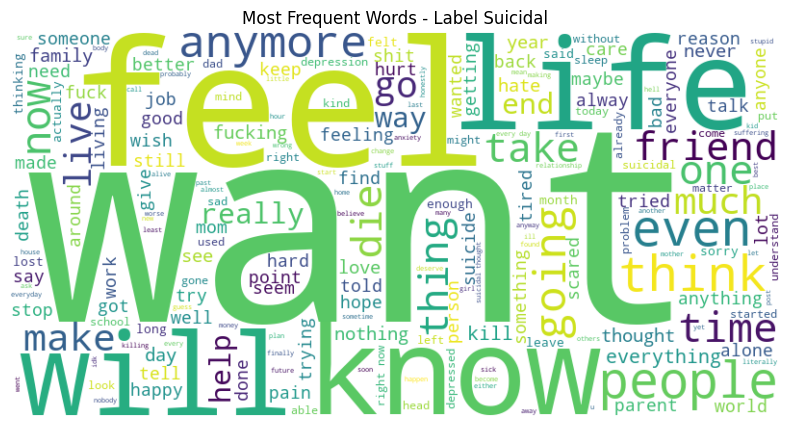

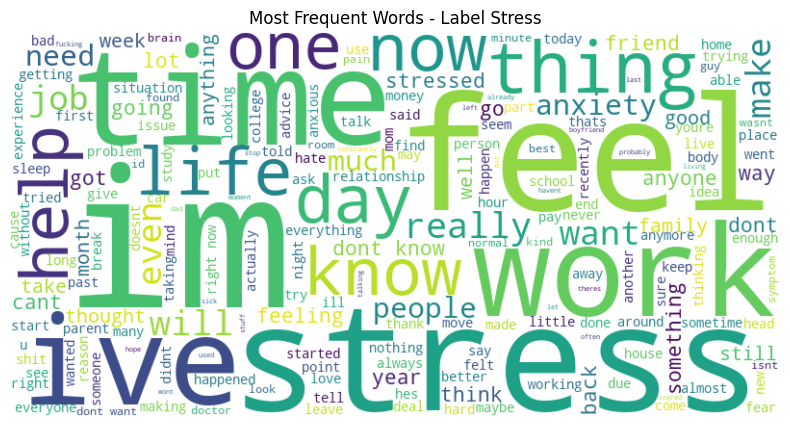

In [18]:
df_wordcloud = dataset['train'].to_pandas()

for label in df_wordcloud['labels'].unique():
    # combine all text for this label
    text = " ".join(df_wordcloud[df_wordcloud['labels'] == label]['text'].astype(str))
    
    # generate word cloud
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    # plot
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Most Frequent Words - Label {label}")
    plt.show()


### **8. Pre-process and Encode Label**

Flattening the indices:   0%|          | 0/48820 [00:00<?, ? examples/s]

Map:   0%|          | 0/48820 [00:00<?, ? examples/s]

labels
1    16339
2    15404
3    10649
0     3841
4     2587
Name: count, dtype: int64


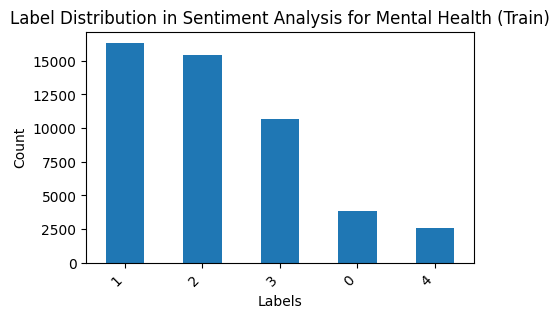

In [19]:
# Get unique labels
labels = dataset["train"].unique("labels")
label_to_id = {l: i for i, l in enumerate(labels)}
id_to_label = {i: l for l, i in label_to_id.items()}

def make_label_encoder(label_to_id: dict, column_name: str = "labels"):
    """Returns a function that encodes labels for the given column using label_to_id mapping."""
    def encode_labels(example):
        example[column_name] = label_to_id[example[column_name]]
        return example
    return encode_labels

encoder_for_data = make_label_encoder(label_to_id, column_name="labels")

dataset = dataset.map(encoder_for_data)

# Re check if changes were applied correctly
label_visualization()

### **9. Split dataset**

In [20]:
def split_dataset_to_train_valid_test(dataset: DatasetDict, test_size: float = 0.2, val_size: float = 0.2, seed: int = 42) -> DatasetDict:
    """
    Splits a dataset into train, validation, and test sets.
    - First, takes a portion (test_size) from 'train' to make the test set.
    - Then, splits the remaining train into train/validation (val_size).
    """
    if "train" not in dataset:
        raise ValueError("DatasetDict must contain a 'train' split.")

    # Split into train + test
    data = dataset["train"].train_test_split(test_size=test_size, seed=seed)
    original_train = data["train"]
    original_test = data["test"]

    # Split original train further into train + validation
    train_valid_split = original_train.train_test_split(test_size=val_size, seed=seed)

    return DatasetDict({
        "train": train_valid_split["train"],
        "validation": train_valid_split["test"],
        "test": original_test
    })

dataset = split_dataset_to_train_valid_test(dataset)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 31244
    })
    validation: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 7812
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 9764
    })
})


---
## **Model Training / Fine-tuning**

### **1. Define model training functions**

#### **a. load tokenizer + model**

In [21]:
def load_model_and_tokenizer(model_name: str, labels: list[str], id2label: dict[int, str], label2id: dict[str, int]):
    """
    Loads a tokenizer and model for sequence classification.

    Args:
        model_name (str): Hugging Face model name or path.
        labels (list[str]): List of labels for classification.
        id2label (dict[int, str]): Mapping from ID to label name.
        label2id (dict[str, int]): Mapping from label name to ID.

    Returns:
        tokenizer, model
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id
    )
    return tokenizer, model

def tokenize_dataset(dataset: Dataset, tokenizer: PreTrainedTokenizerBase, max_length: int = 256, num_proc: int = 4):
    return dataset.map(
        lambda examples: tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=max_length,
        ),
        batched=True,
        num_proc=num_proc
    )


#### **b. check max length to use**

In [94]:
def plot_token_length_distribution(dataset, text_column='text', dataset_name="Dataset"):
    """
    Plots the distribution of sentence lengths or token lengths.
    
    Args:
        dataset: Hugging Face Dataset (tokenized or raw).
        text_column: Name of the column to measure length on. 
                     Use 'text' for raw strings or 'input_ids' for tokenized lists.
        dataset_name: Optional name for labeling the plot.
    """
    # Check first row type to decide how to measure length
    first_elem = dataset[0][text_column]
    
    if isinstance(first_elem, list):  # tokenized
        lengths = [len(x) for x in dataset[text_column]]
        unit = "tokens"
    elif isinstance(first_elem, str):  # raw text
        lengths = [len(x.split()) for x in dataset[text_column]]  # measure words
        unit = "words"
    else:
        raise ValueError(f"Column {text_column} has unsupported type: {type(first_elem)}")
    
    print(f"{dataset_name} {unit} stats:")
    print('Max length:', max(lengths))
    print('Min length:', min(lengths))
    
    plt.figure(figsize=(5, 2))
    plt.hist(lengths, bins=50, rwidth=0.9)
    plt.xlabel(f'Sequence Length ({unit})', fontsize=6)
    plt.ylabel('# of Samples', fontsize=6)
    plt.title(f'{unit.capitalize()} Length Distribution for {dataset_name}', fontsize=10)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.show()

#### **c. compute class weight**

In [25]:
def compute_class_weights(dataset, label_column="labels", device="cpu"):
    """
    Compute normalized class weights from a dataset.

    Args:
        dataset: Hugging Face Dataset split (e.g. dataset["train"])
        label_column: name of the label column
        device: "cpu" or "cuda"

    Returns:
        torch.tensor of class weights
    """
    labels = np.array(dataset[label_column])
    class_counts = np.bincount(labels)

    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum() * len(class_counts)

    return torch.tensor(class_weights, dtype=torch.float).to(device)

### **2. Define Reusable Classes**

#### **a. Focal Loss**

In [96]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

#### **b. Weighted Trainer**

In [97]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        labels = labels.to(logits.device)

        # Use CrossEntropyLoss with class weights
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device) if self.class_weights is not None else None)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

### **3. Train / Fine-tune model**

In [23]:
# Load tokenizer and model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH_MODEL_1,
    num_labels=len(labels),          # dataset 2 label count
    id2label=id_to_label,            # dataset 2 id->label mapping
    label2id=label_to_id,             # dataset 2 label->id mapping
    ignore_mismatched_sizes = True
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH_MODEL_1)

# Tokenize dataset
dataset = tokenize_dataset(
    dataset=dataset,
    tokenizer=tokenizer,
    max_length=512,
    num_proc=4
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at ../../../models/nlp/xlm-roberta/phase-1/sentiment_model and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map (num_proc=4):   0%|          | 0/31244 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/7812 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/9764 [00:00<?, ? examples/s]

In [26]:
# Set format for PyTorch
dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)

# Compute class weight
class_weights_1 = compute_class_weights(dataset["train"], label_column="labels", device="cuda")

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    acc = accuracy.compute(predictions=preds, references=p.label_ids)
    f1_score = f1.compute(predictions=preds, references=p.label_ids, average="macro")
    
    return {**acc, **f1_score}

training_args = TrainingArguments(
    output_dir=MODEL_PATH_FINETUNE,

    # Evaluation & saving
    eval_strategy="steps",             # evaluate more frequently
    eval_steps=500,                    # evaluate every 500 steps
    save_strategy="steps",             # save every eval
    save_steps=500,
    save_total_limit=3,                # keep last 3 checkpoints

    # Optimizer
    learning_rate=2e-5,
    warmup_ratio=0.1,                  # 10% warmup               
    weight_decay=0.05,                 # helps reduce overfitting

    # Batch size
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,     # effective batch size 16

    # Mixed precision
    fp16=True,                         # faster training

    # Training length
    num_train_epochs=5,                # shorter to prevent overfitting
    load_best_model_at_end=True,       # load checkpoint with best validation loss
    metric_for_best_model="f1",  # choose metric to track best model

    # Misc
    dataloader_num_workers=4,
    # logging_steps=100,                 # logs every 100 steps
    # logging_dir=f"{MODEL_PATH_FINETUNE_1}/logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],  # <-- use validation here
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

last_checkpoint = get_last_checkpoint(MODEL_PATH_FINETUNE)

trainer.train(resume_from_checkpoint=last_checkpoint)

C:\Users\PC\AppData\Local\Temp\ipykernel_6568\2066880617.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1
500,1.145100,0.731862,0.710701,0.561168
1000,0.666400,0.591829,0.753456,0.719130
1500,0.549200,0.531144,0.789171,0.744837
2000,0.501900,0.499287,0.795571,0.772160
2500,0.441600,0.515424,0.793523,0.769923
3000,0.444800,0.502025,0.795827,0.774795
3500,0.437800,0.465820,0.816564,0.788932
4000,0.417800,0.473651,0.817972,0.795273
4500,0.362700,0.472636,0.818100,0.805944
5000,0.349300,0.506204,0.813108,0.767720


TrainOutput(global_step=9765, training_loss=0.40083547886127213, metrics={'train_runtime': 5866.3834, 'train_samples_per_second': 26.63, 'train_steps_per_second': 1.665, 'total_flos': 4.110431621572608e+16, 'train_loss': 0.40083547886127213, 'epoch': 5.0})

In [27]:
# Save model and tokenizer
model.save_pretrained(MODEL_PATH_MODEL)
tokenizer.save_pretrained(MODEL_PATH_MODEL)

('../../../models/nlp/xlm-roberta/phase-2/sentiment_model\\tokenizer_config.json',
 '../../../models/nlp/xlm-roberta/phase-2/sentiment_model\\special_tokens_map.json',
 '../../../models/nlp/xlm-roberta/phase-2/sentiment_model\\tokenizer.json')

---
## **Model Evaluation**

### **1. Load The Model & Tokenizer**

In [28]:
model_test = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH_MODEL)
tokenizer_test = AutoTokenizer.from_pretrained(MODEL_PATH_MODEL)

### **2. Test The Model by Making Predictions**

In [29]:
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

model_test.to("cuda") # Ensure that model is loaded in the GPU
model_test.eval()

# Torch DataLoader for test set
test_loader = DataLoader(dataset["test"], batch_size=32)  # increase batch size if possible

all_preds_1 = []
all_labels_1 = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
        # Move to GPU if available
        batch = {k: v.to(model_test.device) for k, v in batch.items() if k in ["input_ids", "attention_mask", "labels"]}

        outputs = model_test(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds_1.extend(preds.cpu().numpy())
        all_labels_1.extend(batch["labels"].cpu().numpy())

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 3060


Evaluating: 100%|██████████| 306/306 [02:51<00:00,  1.78batch/s]


### **3. Compute dataset baseline**

In [30]:
def compute_baselines(hf_dataset_split, label_names=None, n_sim=1000, seed=42):
    """
    hf_dataset_split: a HuggingFace Dataset split (e.g. dataset['train'])
    label_names: optional list of label names in index order (for pretty printing)
    n_sim: number of simulations for random(prior) baseline estimation
    """
    rng = np.random.default_rng(seed)
    labels = np.array(hf_dataset_split["labels"])
    n = len(labels)
    counts = Counter(labels)
    num_labels = len(counts)
    # class prior distribution from data
    class_priors = np.array([counts.get(i, 0) for i in range(max(counts.keys())+1)], dtype=float)
    class_priors = class_priors / class_priors.sum()

    print("Total examples:", n)
    print("Class counts:", counts)
    if label_names:
        for i, name in enumerate(label_names):
            print(f"  {i}: {name} -> {counts.get(i,0)}")

    # 1) majority class baseline
    majority_label = max(counts.items(), key=lambda x: x[1])[0]
    majority_preds = np.full_like(labels, fill_value=majority_label)
    maj_acc = accuracy_score(labels, majority_preds)
    maj_macro_f1 = f1_score(labels, majority_preds, average="macro")
    print(f"\nMajority baseline: predict class {majority_label} (count={counts[majority_label]})")
    print(f"  Accuracy = {maj_acc:.4f}")
    print(f"  Macro-F1 = {maj_macro_f1:.4f}")

    # 2) expected random(prior) baseline — analytic expected accuracy = sum(p_i * p_i)
    expected_acc_analytic = np.sum(class_priors * class_priors)
    print(f"\nRandom(prior) analytic expected accuracy = sum(p_i^2) = {expected_acc_analytic:.4f}")

    # 3) simulate random(prior) baseline to get expected macro-f1 too
    sim_accs = []
    sim_macro_f1s = []
    for _ in range(n_sim):
        sim_preds = rng.choice(len(class_priors), size=n, p=class_priors)
        sim_accs.append(accuracy_score(labels, sim_preds))
        sim_macro_f1s.append(f1_score(labels, sim_preds, average="macro"))
    print(f"Random(prior) simulated (n={n_sim}):")
    print(f"  Accuracy mean = {np.mean(sim_accs):.4f} (std {np.std(sim_accs):.4f})")
    print(f"  Macro-F1 mean = {np.mean(sim_macro_f1s):.4f} (std {np.std(sim_macro_f1s):.4f})")

    # 4) show trivial classification report for majority baseline
    print("\nClassification report for majority baseline (per-class):")
    print(classification_report(labels, majority_preds, zero_division=0, target_names=label_names))

    return {
        "counts": counts,
        "class_priors": class_priors,
        "majority_label": majority_label,
        "majority_acc": maj_acc,
        "majority_macro_f1": maj_macro_f1,
        "random_prior_acc_mean": np.mean(sim_accs),
        "random_prior_macro_f1_mean": np.mean(sim_macro_f1s),
    }

# Example usage (adjust variable names if needed):
# If you have label names, pass them as label_names list.
# For your grouped Dataset 1 example:
# label_names = ["Positive","Anxiety","Sadness","Anger"]  # or whatever mapping you used
baselines = compute_baselines(dataset["train"], label_names=None, n_sim=2000)

Total examples: 31244
Class counts: Counter({np.int64(1): 10550, np.int64(2): 9765, np.int64(3): 6797, np.int64(0): 2445, np.int64(4): 1687})

Majority baseline: predict class 1 (count=10550)
  Accuracy = 0.3377
  Macro-F1 = 0.1010

Random(prior) analytic expected accuracy = sum(p_i^2) = 0.2681
Random(prior) simulated (n=2000):
  Accuracy mean = 0.2681 (std 0.0024)
  Macro-F1 mean = 0.2001 (std 0.0022)

Classification report for majority baseline (per-class):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2445
           1       0.34      1.00      0.50     10550
           2       0.00      0.00      0.00      9765
           3       0.00      0.00      0.00      6797
           4       0.00      0.00      0.00      1687

    accuracy                           0.34     31244
   macro avg       0.07      0.20      0.10     31244
weighted avg       0.11      0.34      0.17     31244



### **4. Use Evaluation/Classification Metrics**

#### **a. Accuracy**

In [31]:
acc_1 = accuracy_score(all_labels_1, all_preds_1)
print(f"Accuracy:  {acc_1:.4f}")

Accuracy:  0.8314


#### **b. Macro F1**

In [32]:
f1_1 = f1_score(all_labels_1, all_preds_1, average="macro")
print(f"F1 Score:  {f1_1:.4f}")

F1 Score:  0.8156


#### **c. Recall**

In [33]:
recall_1 = recall_score(all_labels_1, all_preds_1, average="macro")
print(f"Recall:    {recall_1:.4f}")

Recall:    0.8259


#### **d. Precision**

In [34]:
precision_1 = precision_score(all_labels_1, all_preds_1, average="macro")
print(f"Precision: {precision_1:.4f}")

Precision: 0.8073


#### **e. Metrics Comparison**

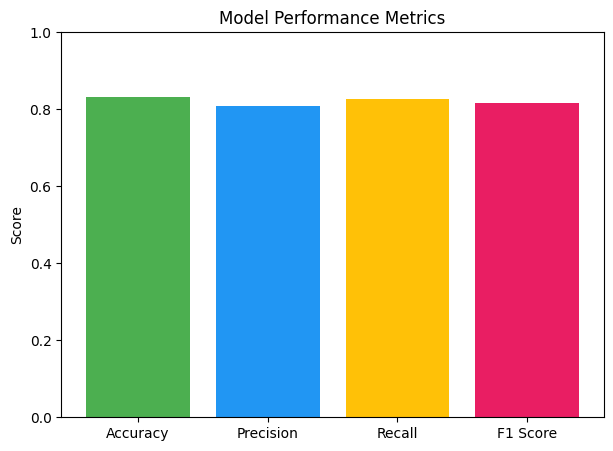

In [35]:
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [acc_1, precision_1, recall_1, f1_1]

plt.figure(figsize=(7,5))
plt.bar(metrics, values, color=["#4CAF50", "#2196F3", "#FFC107", "#E91E63"])
plt.ylim(0, 1)  # scores are between 0 and 1
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.show()

#### **f. Confusion Matrix**

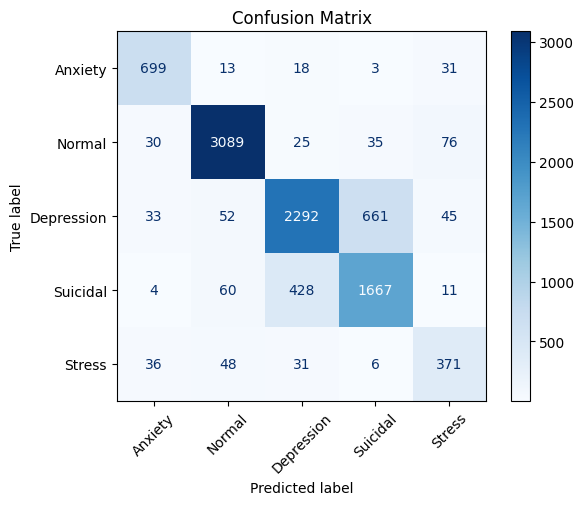

In [36]:
# Sort display labels by their id so order matches your encoded labels
display_labels = [id_to_label[i] for i in range(len(id_to_label))]

disp = ConfusionMatrixDisplay.from_predictions(all_labels_1, all_preds_1, cmap="Blues", xticks_rotation=45, display_labels=display_labels)
plt.title("Confusion Matrix")
plt.show()

#### **g. Confusion Matrix (Percentage)**

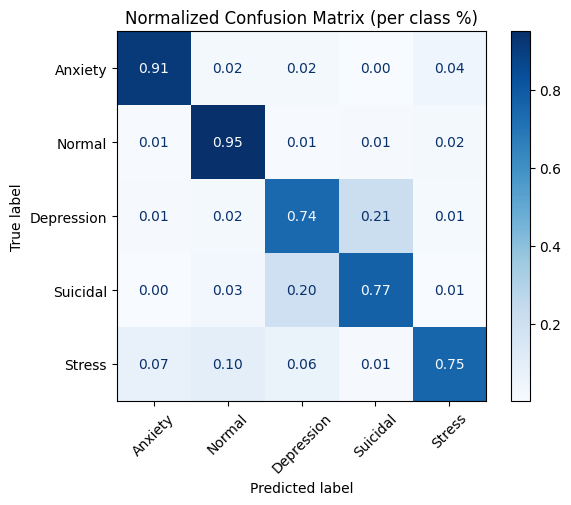

In [37]:
# Compute confusion matrix
cm = confusion_matrix(all_labels_1, all_preds_1, normalize="true")  # normalize rows (true labels)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap="Blues", xticks_rotation=45, values_format=".2f")  # 2 decimal places
plt.title("Normalized Confusion Matrix (per class %)")
plt.show()